In [1]:
import NN
import h5py
import json
import time
import pyccl
import scipy
import numpy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

In [2]:
#Data path

TYPE = 'II'
PATH = '/pscratch/sd/y/yhzhang/TensorCloud/'

DATA_PATH = PATH + 'DATA/'
PLOT_PATH = PATH + 'PLOT/' + TYPE + '/'

In [3]:
#Load in Data

BIN_SIZE = 4
GRID_SIZE = 128
DATA_SIZE = 100000

with h5py.File(DATA_PATH + 'DATA.hdf5','r') as DATA:
    
    REDSHIFT_GRID = numpy.array(DATA['realizations/z'][:GRID_SIZE], dtype = 'float32')
    DATA_GRID = numpy.array(DATA['realizations/pdfs'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'float32')

In [4]:
# COSMOLOGY

with open(DATA_PATH + 'COSMO.json', 'r') as cosmo:
    
    COSMO = json.load(cosmo)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu = COSMO['MNU'],  
    Neff = COSMO['NEFF'],
    T_CMB = COSMO['TCMB'], 
    Omega_k = COSMO['OMEGAK'], 
    Omega_c = COSMO['OMEGAC'], 
    Omega_b = COSMO['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 2000, 'lmax': 2000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [5]:
#Restrcture the data

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'float32')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

ELL_SIZE = 200
ELL_DATA = numpy.logspace(2, 4, ELL_SIZE + 1)
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, GRID_SIZE)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
for GRID_INDEX in range(GRID_SIZE):

    POWER_GRID[:,GRID_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

GROWTH_RATE = pyccl.background.growth_rate(cosmo=COSMO_CCL,a = A_GRID)

In [6]:
#Define angular power spectrum

def c_m1_m2(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, growth_grid, type):

    pii = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid/growth_grid, kind = type)
    
    phi_m2 = scipy.interpolate.interp1d(chi_grid, phi_m2_grid/growth_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * phi_m2(chi) * pii(chi) / (chi**2)
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

In [7]:
#Compare different numeric equations
AMPLITUDE = (0.0134**2)*(COSMO['OMEGAM'] + COSMO['OMEGAN'])**2 * (1 + 3 / (2 * ELL_DATA + 1)) * (1 + 1 / (2 * ELL_DATA + 1)) * (1 - 1 / (2 * ELL_DATA + 1)) * (1 - 3 / (2 * ELL_DATA + 1))
C_DATA = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
C_DATA1 = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
C_DATA2 = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
C_DATA3 = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
C_CCL = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))

POWER_test_GRID=numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
IAb=numpy.ones(len(REDSHIFT_GRID))
for i in range(len(REDSHIFT_GRID)):
    IAb[i] = 0.0134 * (COSMO['OMEGAM'] + COSMO['OMEGAN']) /GROWTH_RATE[i]
IA_bias=[REDSHIFT_GRID, IAb]
for i in range(ELL_SIZE + 1):
    for j in range(GRID_SIZE):
        POWER_test_GRID[i][j] =POWER_GRID[i][j]*(IAb[j]**2)
T0 = time.time()
C_DATA = NN.function(amplitude = 1, phi_grid = PHI_GRID, chi_grid = CHI_GRID, power_grid = POWER_test_GRID, redshift_grid = REDSHIFT_GRID)
T1 = time.time()
T_TC=T1 - T0
T_pyccl=0
for (BIN_INDEX1, BIN_INDEX2) in product(range(BIN_SIZE), range(BIN_SIZE)):
    
    T0 = time.time()
    TRACER1 = pyccl.tracers.WeakLensingTracer(cosmo = COSMO_CCL, dndz = [REDSHIFT_GRID, PSI_GRID[BIN_INDEX1,:]], has_shear = False, ia_bias = IA_bias, use_A_ia = False, n_samples = GRID_SIZE)
    TRACER2 = pyccl.tracers.WeakLensingTracer(cosmo = COSMO_CCL, dndz = [REDSHIFT_GRID, PSI_GRID[BIN_INDEX2,:]], has_shear = False, ia_bias = IA_bias, use_A_ia = False, n_samples = GRID_SIZE)
    
    pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = False
    pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
    C_CCL[BIN_INDEX1, BIN_INDEX2,:] = pyccl.cells.angular_cl(cosmo = COSMO_CCL, tracer1 = TRACER1, tracer2 = TRACER2, ell = ELL_DATA, p_of_k_a = COSMO_CCL.get_camb_pk_lin(nonlin = False), l_limber = - 1.0, limber_integration_method = 'spline')
    T1 = time.time()
    T_pyccl=T_pyccl+T1-T0
    for ELL_INDEX in range(ELL_SIZE + 1):
        C_DATA1[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = PHI_GRID[BIN_INDEX1,:], phi_m2_grid = PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], growth_grid = GROWTH_RATE, type = 'slinear')
        C_DATA2[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = PHI_GRID[BIN_INDEX1,:], phi_m2_grid = PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], growth_grid = GROWTH_RATE, type = 'quadratic')
        C_DATA3[BIN_INDEX1, BIN_INDEX2, ELL_INDEX] = c_m1_m2(amplitude = AMPLITUDE[ELL_INDEX], phi_m1_grid = PHI_GRID[BIN_INDEX1,:], phi_m2_grid = PHI_GRID[BIN_INDEX2,:], chi_grid = CHI_GRID, power_grid = POWER_GRID[ELL_INDEX,:], growth_grid = GROWTH_RATE, type = 'cubic')   
        
    T2 = time.time()
    print(BIN_INDEX1, BIN_INDEX2, T1 - T0, T2 - T1)
print('TensorCloud calculation time for II:%fs' %T_TC)
print('pyccl calculation time for II:%fs' %T_pyccl)
C_RATIO = numpy.divide(C_DATA, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO1 = numpy.divide(C_DATA1, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO2 = numpy.divide(C_DATA2, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO3 = numpy.divide(C_DATA3, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)

0 0 215.5750494003296 0.2749466896057129
0 1 213.18264031410217 0.2629694938659668
0 2 216.7816948890686 0.2645902633666992
0 3 215.96645522117615 0.2665212154388428
1 0 213.82451558113098 0.26524901390075684
1 1 215.72713923454285 0.27442193031311035
1 2 216.64909982681274 0.26479434967041016
1 3 214.9495038986206 0.2877323627471924
2 0 224.5638518333435 0.26337218284606934
2 1 226.67365860939026 0.2773430347442627
2 2 220.64706134796143 0.2666959762573242
2 3 219.53065133094788 0.2779555320739746
3 0 230.77243185043335 0.26413488388061523
3 1 217.55525875091553 0.2667665481567383
3 2 215.87780570983887 0.2650735378265381
3 3 215.99939584732056 0.2655792236328125
TensorCloud calculation time for II:3.104434s
pyccl calculation time for II:3494.276214s


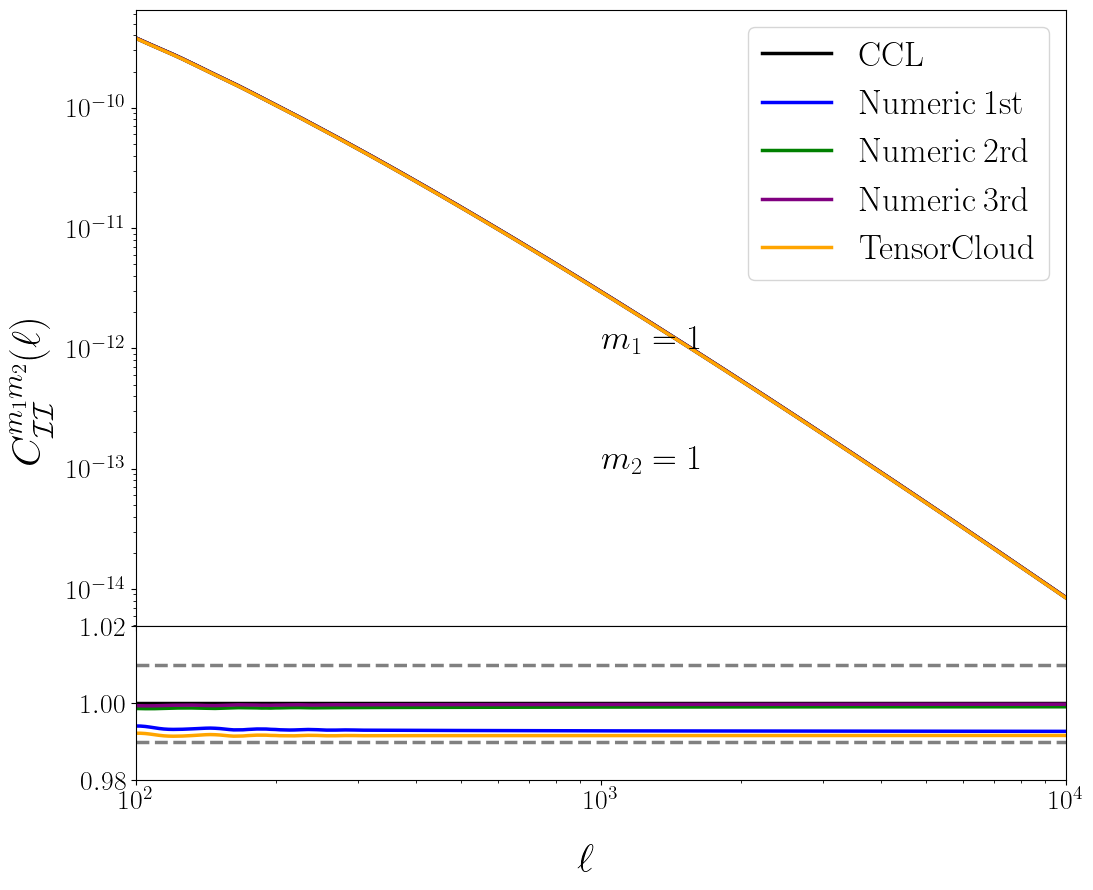

In [8]:
#Plot the results

BIN_INDEX1 = 0
BIN_INDEX2 = 0

pyplot.rcParams['font.size'] = 20
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[:8,:12])

PLOT.plot(ELL_DATA, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(ELL_DATA, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(ELL_DATA, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2rd}$')

PLOT.plot(ELL_DATA, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(ELL_DATA, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 10**3, y = 10**-12, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

PLOT.text(x = 10**3, y = 10**-13, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

PLOT.set_yscale('log')
PLOT.set_xscale('log')
PLOT.set_xlim(100, 10000)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])
PLOT.legend(loc = 'upper right', fontsize = 25)

PLOT = FIGURE.add_subplot(GRIDSPEC[8:10,:12])

PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(ELL_DATA, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(ELL_DATA, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(ELL_DATA, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(ELL_DATA, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xscale('log')
PLOT.set_xlim(100, 10000)
PLOT.set_ylim(0.98, 1.02)
FIGURE.supxlabel(r'$\ell$', fontsize = 30)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{II} (\ell)$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig(PLOT_PATH + 'C_ELL_II.pdf', bbox_inches = 'tight')

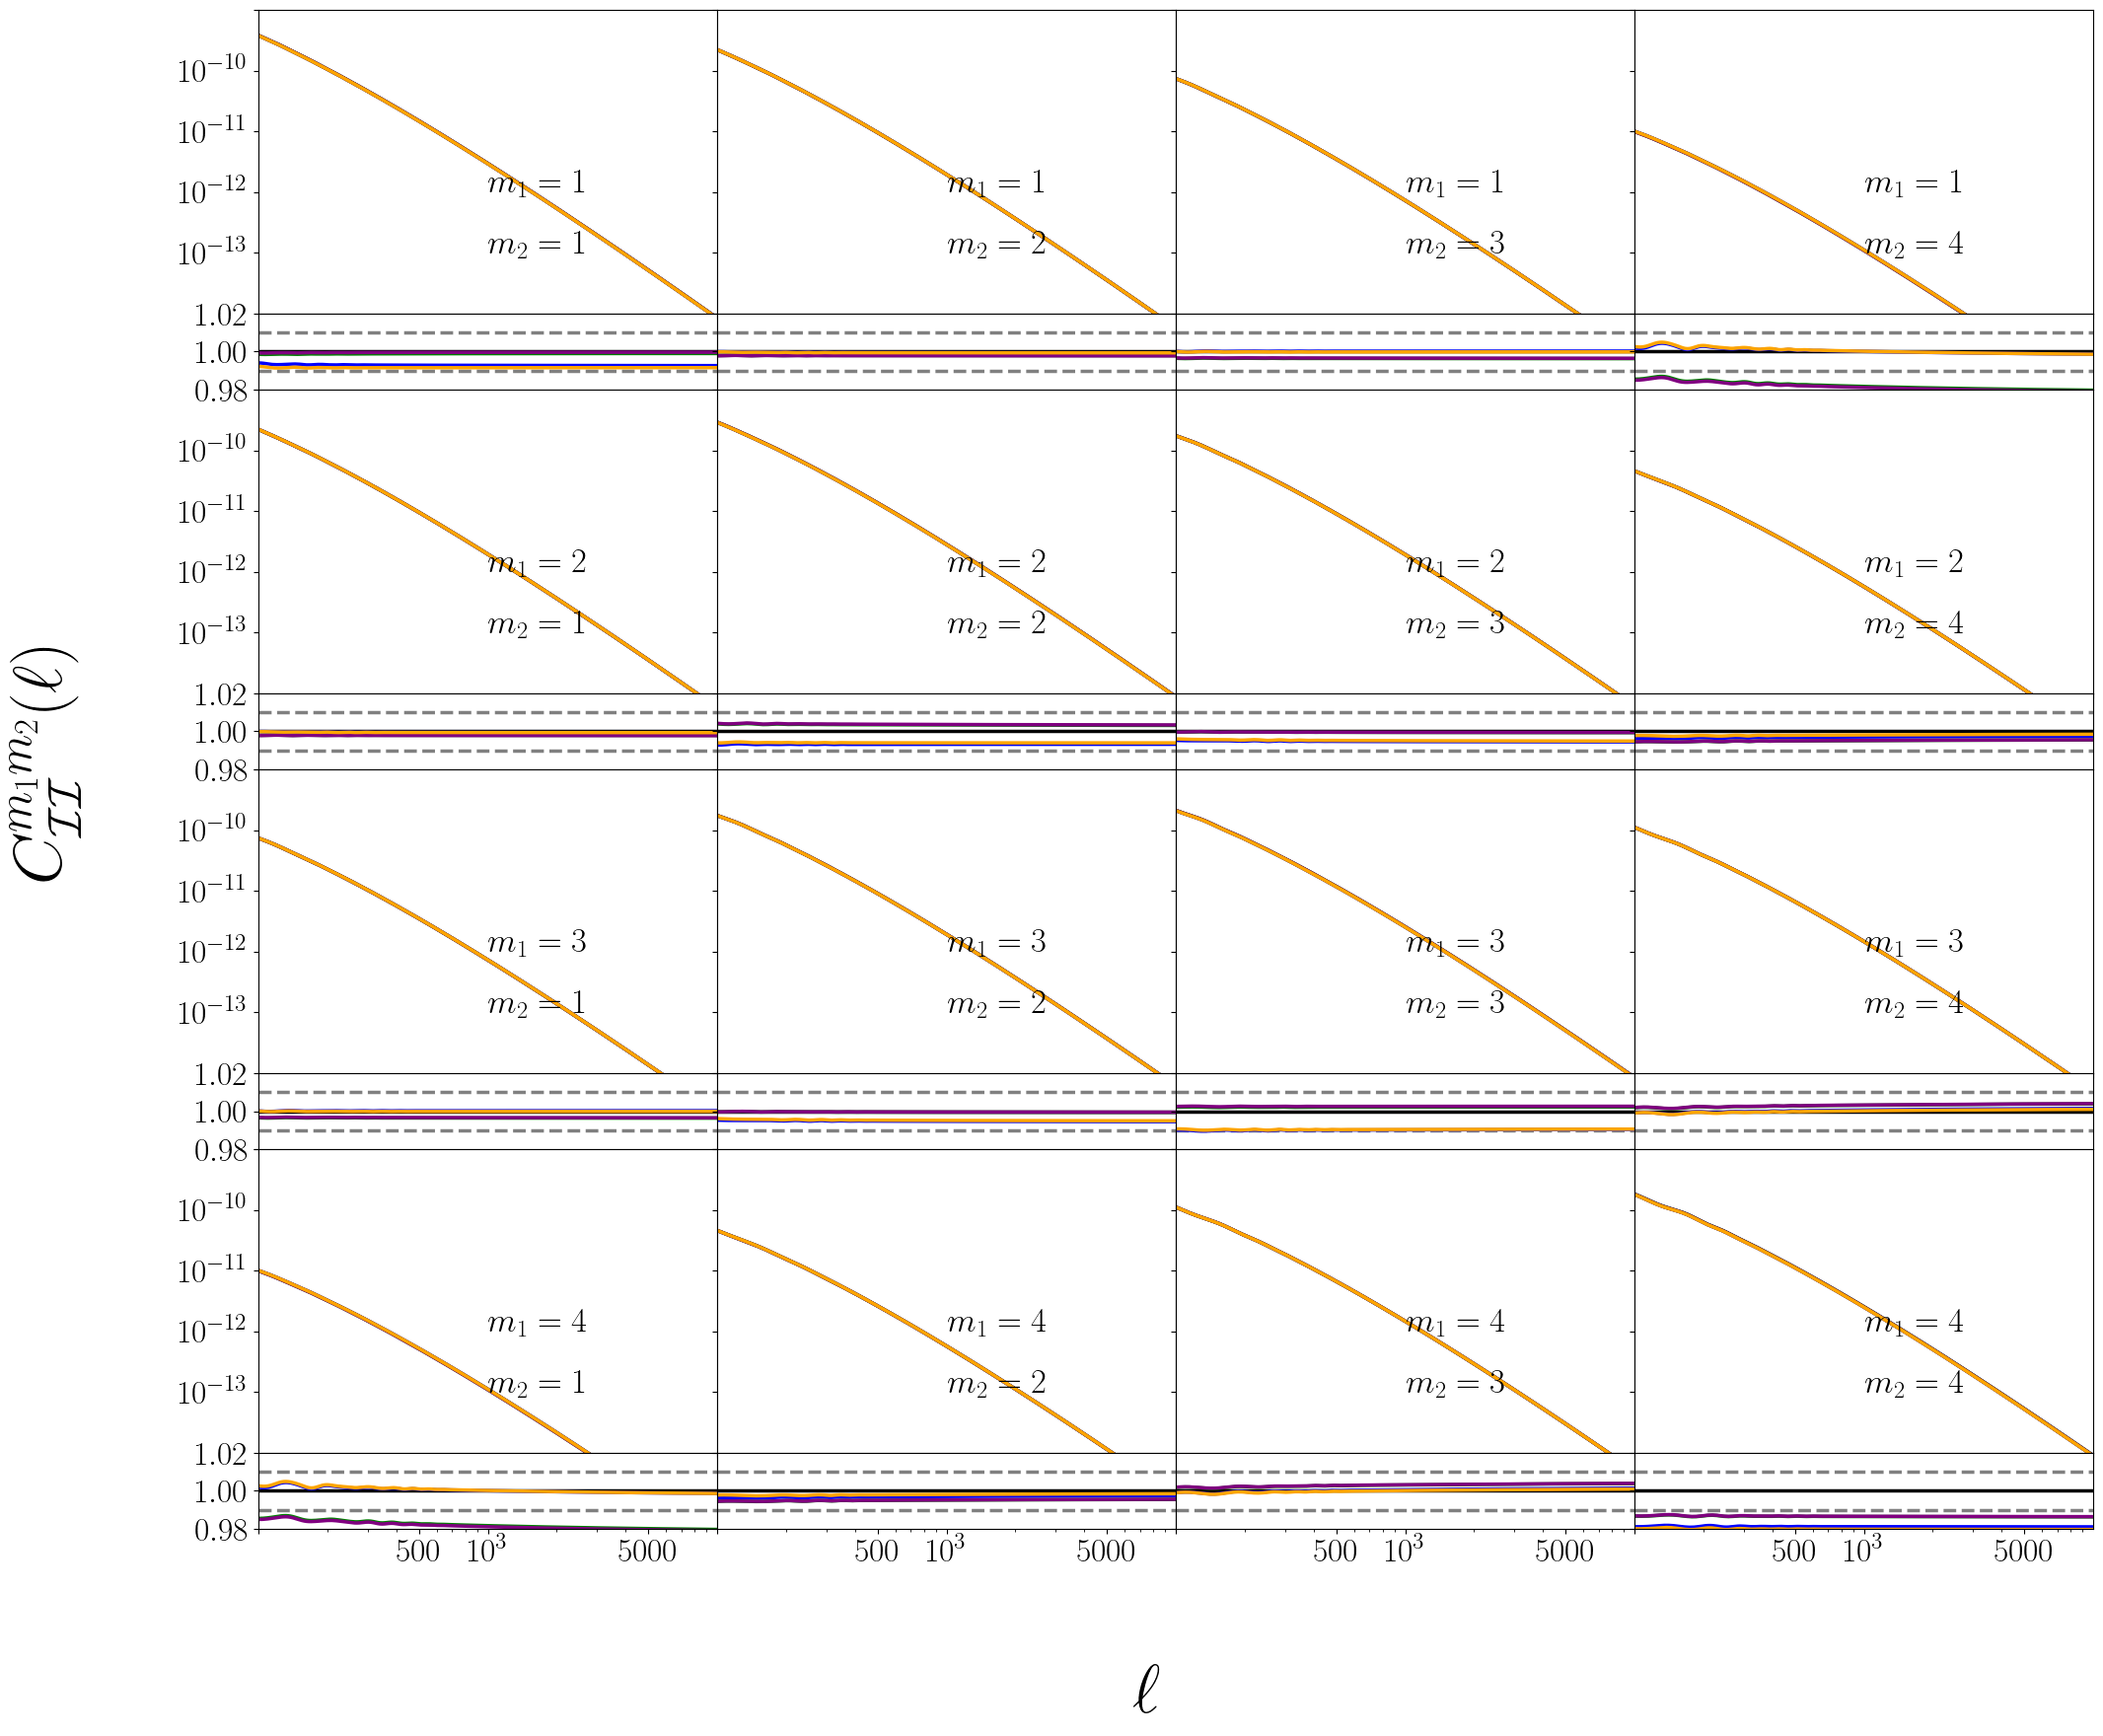

In [17]:
# Compare different bins

pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (BIN_SIZE * 6, BIN_SIZE * 5))
GRIDSPEC = GridSpec(5 * BIN_SIZE, 6 * BIN_SIZE, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(BIN_SIZE), range(BIN_SIZE)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    PLOT.plot(ELL_DATA, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

    PLOT.plot(ELL_DATA, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

    PLOT.plot(ELL_DATA, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2rd}$')
    
    PLOT.plot(ELL_DATA, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

    PLOT.plot(ELL_DATA, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

    PLOT.text(x = 10**3, y = 10**-12, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-13, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 10000)
    PLOT.set_ylim(10**-14, 10**-9)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-9,10**-10, 10**-11, 10**-12, 10**-13]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'', r'${10}^{-10}$', r'${10}^{-11}$', r'${10}^{-12}$', r'${10}^{-13}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ELL_DATA, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ELL_DATA, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
    
    PLOT.plot(ELL_DATA, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ELL_DATA, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 10000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000, 5000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'', r'$500$', r'${10}^3$', r'$5000$']))
    if BIN_INDEX1 < BIN_SIZE - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{II} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig(PLOT_PATH + 'C_M_ELL_II.pdf', bbox_inches = 'tight')